## TensorFlow Titanic training

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

In [48]:
import tensorflow.compat.v2.feature_column as fc
import tensorflow as tf

In [49]:
# Load dataset.
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [50]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [51]:
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: survived, dtype: int64

In [52]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [54]:
dftrain.shape

(627, 9)

<AxesSubplot:>

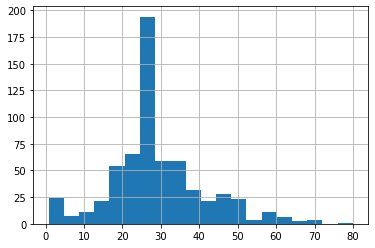

In [55]:
dftrain.age.hist(bins=20)

<AxesSubplot:>

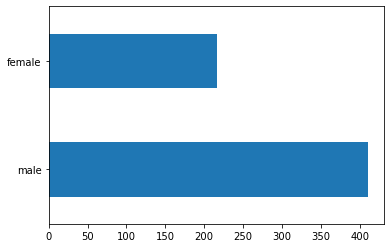

In [56]:
dftrain.sex.value_counts().plot(kind='barh')

<AxesSubplot:>

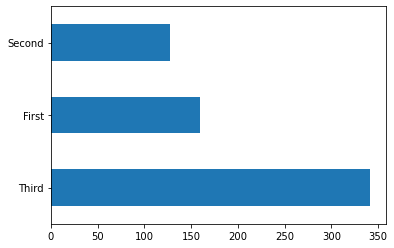

In [57]:
dftrain['class'].value_counts().plot(kind='barh')

Text(0.5, 0, '% survive')

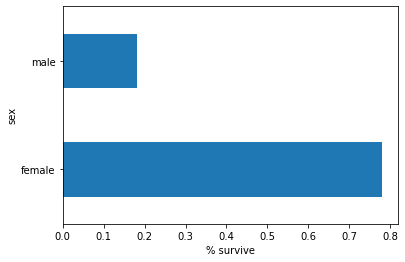

In [58]:
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')

In [59]:
f =pd.concat([dftrain, y_train], axis=1)
f.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone,survived
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n,0
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n,1
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y,1
3,female,35.0,1,0,53.1000,First,C,Southampton,n,1
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y,0


## Feature Engineering for the Model

In [60]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
    vocabulary = dftrain[feature_name].unique()
    feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

In [61]:
feature_columns

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.strin

In [31]:
#The input_function specifies how data is converted to a tf.data.Dataset that feeds the input pipeline 
#in a streaming fashion. tf.data.Dataset can take in multiple sources such as a dataframe, 
#a csv-formatted file, and more.

def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
    def input_function():
        ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
        if shuffle:
            ds = ds.shuffle(1000)
        ds = ds.batch(batch_size).repeat(num_epochs)
        return ds
    return input_function

train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

In [32]:
#You can inspect the dataset:
ds = make_input_fn(dftrain, y_train, batch_size=10)()
for feature_batch, label_batch in ds.take(1):
    print('Some feature keys:', list(feature_batch.keys()))
    print()
    print('A batch of class:', feature_batch['class'].numpy())
    print()
    print('A batch of Labels:', label_batch.numpy())

Some feature keys: ['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck', 'embark_town', 'alone']

A batch of class: [b'Third' b'Third' b'First' b'Second' b'Second' b'Third' b'Second'
 b'Third' b'First' b'Third']

A batch of Labels: [0 0 1 1 1 0 1 1 0 1]


In [43]:
feature_columns[7]

NumericColumn(key='age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)

In [46]:
#You can also inspect the result of a specific feature column using the tf.keras.layers.DenseFeatures layer:
# .numpy() is to_numpy() to convert dataFrame into numpy array
age_column = feature_columns[7]
tf.keras.layers.DenseFeatures([age_column])(feature_batch).numpy()

array([[11. ],
       [14.5],
       [22. ],
       [33. ],
       [34. ],
       [ 9. ],
       [19. ],
       [17. ],
       [47. ],
       [28. ]], dtype=float32)

In [34]:
#DenseFeatures only accepts dense tensors, to inspect a categorical column you need to transform 
#that to a indicator column first:
gender_column = feature_columns[0]
tf.keras.layers.DenseFeatures([tf.feature_column.indicator_column(gender_column)])(feature_batch).numpy()

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [35]:
#After adding all the base features to the model, let's train the model. 
#Training a model is just a single command using the tf.estimator API:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result)

{'accuracy': 0.75757575, 'accuracy_baseline': 0.625, 'auc': 0.81285584, 'auc_precision_recall': 0.7550654, 'average_loss': 0.5502188, 'label/mean': 0.375, 'loss': 0.53998274, 'precision': 0.76119405, 'prediction/mean': 0.26169696, 'recall': 0.5151515, 'global_step': 200}


## Derived Feature Columns

In [36]:
# Now you reached an accuracy of 75%. Using each base feature column separately may not be enough to explain the data. 
# For example, the correlation between age and the label may be different for different gender. 
# Therefore, if you only learn a single model weight for gender="Male" and gender="Female", 
# you won't capture every age-gender combination (e.g. distinguishing between gender="Male" AND age="30" 
# AND gender="Male" AND age="40").

# To learn the differences between different feature combinations, 
# you can add crossed feature columns to the model (you can also bucketize age column before the cross column):

In [37]:
age_x_gender = tf.feature_column.crossed_column(['age', 'sex'], hash_bucket_size=100)

In [38]:
#After adding the combination feature to the model, let's train the model again:
derived_feature_columns = [age_x_gender]
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns+derived_feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result)

{'accuracy': 0.77272725, 'accuracy_baseline': 0.625, 'auc': 0.85166824, 'auc_precision_recall': 0.7857905, 'average_loss': 0.47014427, 'label/mean': 0.375, 'loss': 0.46079922, 'precision': 0.73493975, 'prediction/mean': 0.3281545, 'recall': 0.61616164, 'global_step': 200}


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\User\AppData\Local\Temp\tmp4zi528sk\model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


<AxesSubplot:title={'center':'predicted probabilities'}, ylabel='Frequency'>

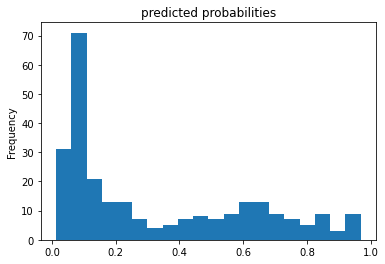

In [39]:
# It now achieves an accuracy of 77.6%, which is slightly better than only trained in base features. 
# You can try using more features and transformations to see if you can do better!

# Now you can use the train model to make predictions on a passenger from the evaluation set. 
# TensorFlow models are optimized to make predictions on a batch, or collection, of examples at once. 
# Earlier, the eval_input_fn was defined using the entire evaluation set.
pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')

(0.0, 1.05)

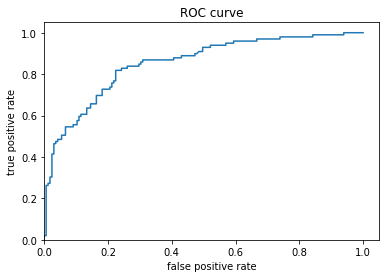

In [40]:
# Finally, look at the receiver operating characteristic (ROC) of the results, 
# which will give us a better idea of the tradeoff between the true positive rate and false positive rate.
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)